In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import datetime
import random
import pandas as pd
import numpy as np

from IPython import display
from gan.gan_dataset import get_gan_dataset
from gan.gan_models import make_discriminator_model
from src.generators import *
from src.models import *
from src.losses import *

batch_size = 12

gan_size = 64
gan_depth = 1
gan_train_frac = 0.8
gan_val_frac = 0.1

src_window_size = 2
src_sample_size = 12
src_tile_size = 64
src_seed_size = 100

epochs = 50


src_data_dir = "training_data"


src_train_ids = np.load(src_data_dir + '/train_ids.npy')
src_val_ids = np.load(src_data_dir + '/val_ids.npy')
mean, std, src_train_dataset = get_src_dataset(src_data_dir, src_train_ids, src_window_size, batch_size = batch_size)
mean, std, src_val_dataset = get_src_dataset(src_data_dir, src_val_ids, src_window_size, batch_size = batch_size)


2023-08-03 15:31:00.734351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 15:31:00.857244: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 15:31:03.834416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 15:31:03.894360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA no

In [60]:
test_dir = "testing_data"
src_test_ids = np.load(test_dir + '/train_ids.npy')
np.random.shuffle(src_test_ids)
test_mean, test_std, src_test_dataset = get_src_dataset(test_dir, src_test_ids, src_window_size, batch_size=batch_size)

In [3]:
!pip install pykrige

In [4]:
from evaluate_models import *

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
#Slide 5: Full, cloud, and masked
from pathlib import Path

In [7]:
for batch in src_val_dataset:
    sample_batch = batch
    break

In [8]:
def show_baseline(batch_x, batch_y, ind):
    x = batch_x[ind, :, :, :]
    y = batch_y[ind, :, :, :]

    locs = np.where(x != 0)

    gridx = np.arange(0.0, x.shape[1])
    gridy = np.arange(0.0, x.shape[2])
    gridz = np.arange(0.0, x.shape[0])
    arr = np.zeros((len(locs[0]), 4))

    data_arr = x[locs[0], locs[1], locs[2]]

    arr[:, 0] = locs[2]
    arr[:, 1] = locs[1]
    arr[:, 2] = locs[0]
    arr[:, 3] = data_arr
    uk3d = UniversalKriging3D(
        arr[:1000, 0], arr[:1000, 1], arr[:1000, 2], arr[:1000, 3], variogram_model="linear", verbose=False
    )
    print("Done")
    vals, ss3d = uk3d.execute("grid", gridx, gridy, gridz)
    return vals

In [9]:
def baseline_predict(np_input):
    
    block = np_input
    locs = np.where(block != 0)

    gridx = np.arange(0.0, block.shape[1])
    gridy = np.arange(0.0, block.shape[2])
    gridz = np.arange(0.0, block.shape[0])
    arr = np.zeros((len(locs[0]), 4))

    data_arr = block[locs[0], locs[1], locs[2]]

    #print(arr.shape)
    #print(data_arr.shape)
    arr[:, 0] = locs[2]
    arr[:, 1] = locs[1]
    arr[:, 2] = locs[0]
    arr[:, 3] = data_arr
    np.random.shuffle(arr)
    #print(arr[:100])
    uk3d = UniversalKriging3D(
        arr[:100, 0], arr[:100, 1], arr[:100, 2], arr[:100, 3], variogram_model="linear", verbose=False
    )
    print("Done")
    vals, ss3d = uk3d.execute("grid", gridx, gridy, gridz)
    
    return vals
    
    

In [10]:
def unseeded_model_predict(tf_input, model):
    return model(tf_input, training=False)

def seeded_model_predict(tf_input, model, src_seed_size):
    noise = tf.random.normal([tf_input.shape[0], src_seed_size])
    return model([tf_input, noise], training=False)

In [19]:
def all_predicts(tf_batch, models = []):
    
    
    tf_x, tf_y = tf_batch

    tf_pred_models = []
    for model in models:
        if model['seeded']:
            model['pred'] = tf.reshape(seeded_model_predict(tf_x, model['model']), tf_y.shape)
        else:
            model['pred'] = tf.reshape(unseeded_model_predict(tf_x, model['model']), tf_y.shape)
        tf_pred_models.append(model)
                            
    
    return tf_x, tf_y, tf_pred_models
    
def all_predicts_np(tf_batch, models = []):
    
    
    tf_x, tf_y = tf_batch
    
    np_x = tf_x.numpy()
    np_y = tf_y.numpy()

    np_pred_models = []
    for model in models:
        if model['seeded']:
            model['pred'] = (tf.reshape(seeded_model_predict(tf_x, model['model'], 100), tf_y.shape)).numpy()
        else:
            model['pred'] = (tf.reshape(unseeded_model_predict(tf_x, model['model']), tf_y.shape)).numpy()
        np_pred_models.append(model)
                            
    
    return np_x, np_y, np_pred_models
    
    

In [51]:
def np_mse_loss(np_true, np_pred):
    valid = (~np.isnan(np_true))
    num_valid = np.sum(valid)
    return np.sum(np.square(np_true[valid] - np_pred[valid])) / num_valid


def show_hour_np(np_x, np_y, ind, hour, np_pred_models = []):
    np_x = np_x.copy()
    np_y = np_y.copy()
    np_pred_models = np_pred_models.copy()

    vmin = np.nanmin(np_y[ind, hour, :, :])
    vmax = np.nanmax(np_y[ind, hour, :, :])
    print(vmin, vmax)
    vmin = -4
    vmax = 4
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)  # Adjust vmin and vmax as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    np_pred_baseline = baseline_predict(np_x[ind, :, :, :])
    
    np_x = np_x[ind, hour, :, :]
    np_y = np_y[ind, hour, :, :]
    np_pred_baseline = np_pred_baseline[hour, :, :]
    for i in range(len(np_pred_models)):
        np_pred_models[i] = {'name': np_pred_models[i]['name'], 'pred': np_pred_models[i]['pred'][ind, hour, :, :]}
    
    np_x[np_x == 0] = np.nan
    
    baseline_loss = np_mse_loss(np_y, np_pred_baseline)
    models_loss = [np_mse_loss(np_y, np_model['pred']) for np_model in np_pred_models]
    
    fig, axs = plt.subplots(1, len(np_pred_models) + 3, figsize=(15, 4), sharey=True)
    
    axs[0].imshow(np_x, cmap=cmap, norm=norm)
    axs[0].set_title(f"X, Ind {ind} Hour {hour}")
    axs[1].imshow(np_y, cmap=cmap, norm=norm)
    axs[1].set_title(f"Y, Ind {ind} Hour {hour}")
    
    axs[2].imshow(np_pred_baseline, cmap=cmap, norm=norm)
    axs[2].set_title(f"Baseline, Loss {int(baseline_loss * 1000)/1000}")
    
    for i in range(len(np_pred_models)):
        axs[i+3].imshow(np_pred_models[i]['pred'], cmap=cmap, norm=norm)
        axs[i+3].set_title(f"{np_pred_models[i]['name']}, Loss {int(models_loss[i] * 1000)/1000}")
    
    # Add a color bar on the right of all subplots
    # Create a ScalarMappable object using a color map (you can change 'viridis' to any other colormap)
    
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    plt.colorbar(sm, cax=cax)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Y-axis Label', va='center', rotation='vertical')

    # Adjust the layout to avoid overlapping titles
    plt.tight_layout()

    # Show the plot
    plt.show()
    

def show_hour(tf_batch, ind, hour, models = []):
    np_x, np_y, np_pred_baseline, np_pred_models = all_predicts_np(tf_batch, models)
    
    vmin = np.nanmin(np_y[ind, :, :, :])
    vmax = np.nanmax(np_y[ind, :, :, :])
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)  # Adjust vmin and vmax as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
        
    np_x = np_x[ind, hour, :, :]
    np_y = np_y[ind, hour, :, :]
    np_pred_baseline = np_pred_baseline[ind, hour, :, :]
    np_pred_models = [np_pred_model[ind, hour, :, :] for np_pred_model in np_pred_models]
    
    np_x[np_x == 0] = np.nan
    
    baseline_loss = np_mse_loss(np_y, np_pred_baseline)
    models_loss = [np_mse_loss(np_y, np_model) for np_model in np_pred_models]
    
    fig, axs = plt.subplots(1, len(models) + 3, figsize=(15, 4), sharey=True)
    
    axs[0].imshow(np_x, cmap=cmap, norm=norm)
    axs[0].set_title(f"X, Ind {ind} Hour {hour}")
    axs[1].imshow(np_y, cmap=cmap, norm=norm)
    axs[1].set_title(f"Y, Ind {ind} Hour {hour}")
    
    axs[2].imshow(np_pred_baseline, cmap=cmap, norm=norm)
    axs[2].set_title(f"Baseline, Loss {baseline_loss}")
    
    for i in range(len(models)):
        axs[i+3].imshow(np_pred_models[i], cmap=cmap, norm=norm)
        axs[i+3].set_title(f"Model {i}, Loss {int(models_loss[i] * 1000)/1000}")
    
    # Add a color bar on the right of all subplots
    # Create a ScalarMappable object using a color map (you can change 'viridis' to any other colormap)
    
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    plt.colorbar(sm, cax=cax)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Y-axis Label', va='center', rotation='vertical')

    # Adjust the layout to avoid overlapping titles
    plt.tight_layout()

    # Show the plot
    plt.show()

In [31]:
import copy

In [52]:
np_x, np_y, np_pred_models = all_predicts_np(sample_batch, models)

In [81]:
print(vmin, vmax)

NameError: name 'vmin' is not defined

0
-3.0414894 -1.691025
Done


/tmp/ipykernel_6323/3839167977.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


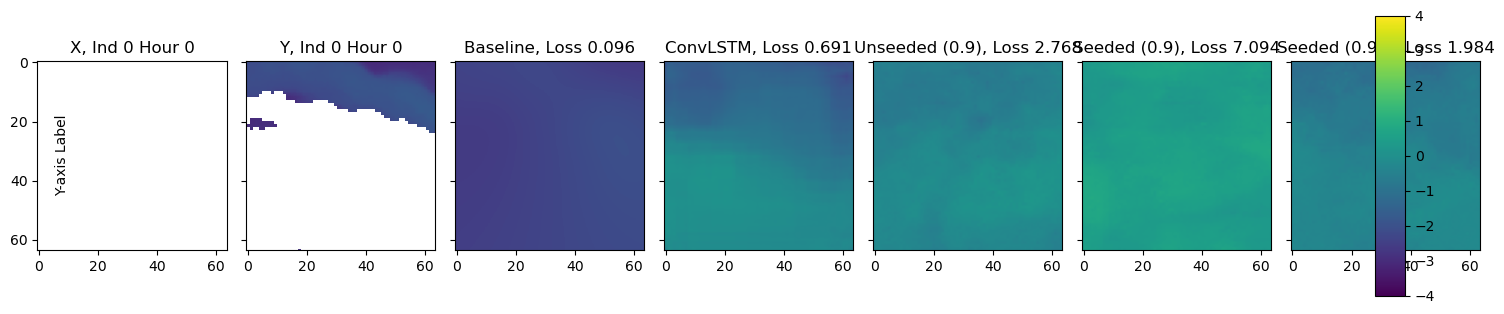

1
-3.2808182 -1.8523866
Done


<Figure size 640x480 with 0 Axes>

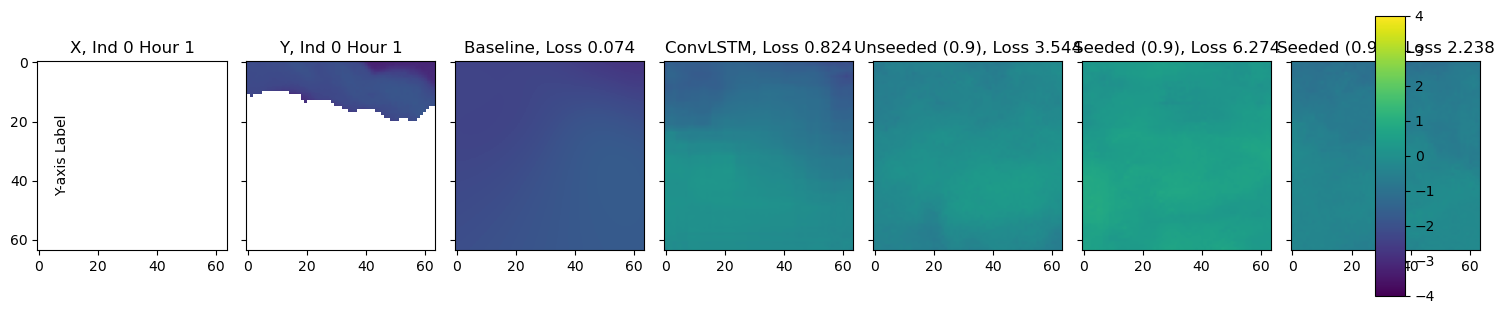

2
-3.3111446 -1.8556386
Done


<Figure size 640x480 with 0 Axes>

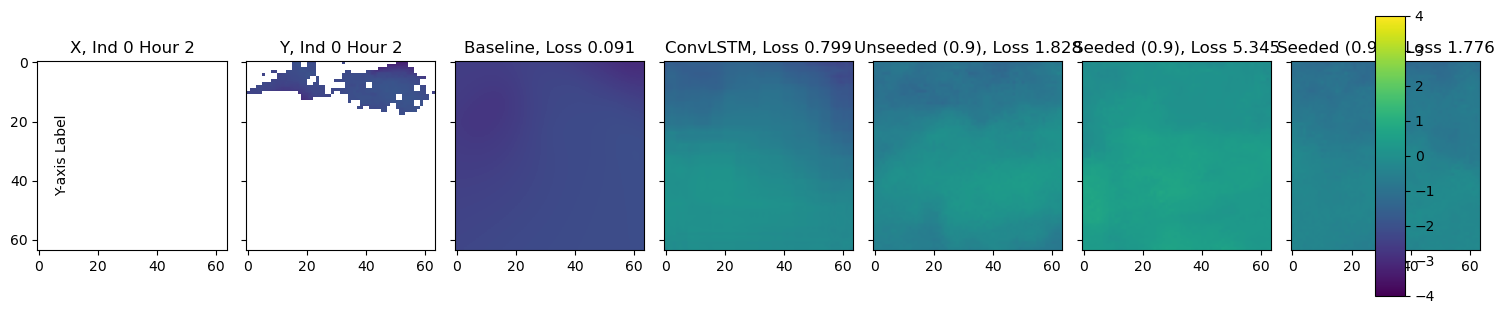

3
-3.3241398 3.3816051
Done


<Figure size 640x480 with 0 Axes>

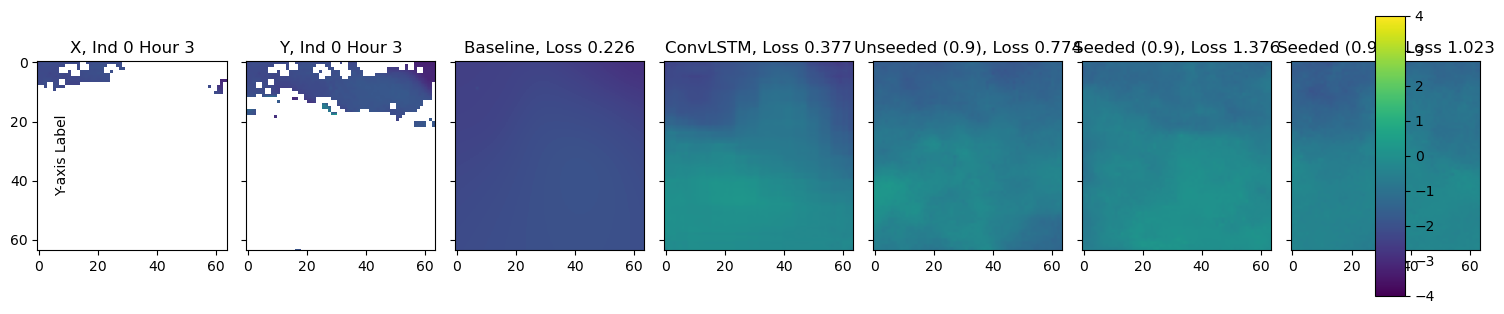

4
-3.3154807 0.6828511
Done


<Figure size 640x480 with 0 Axes>

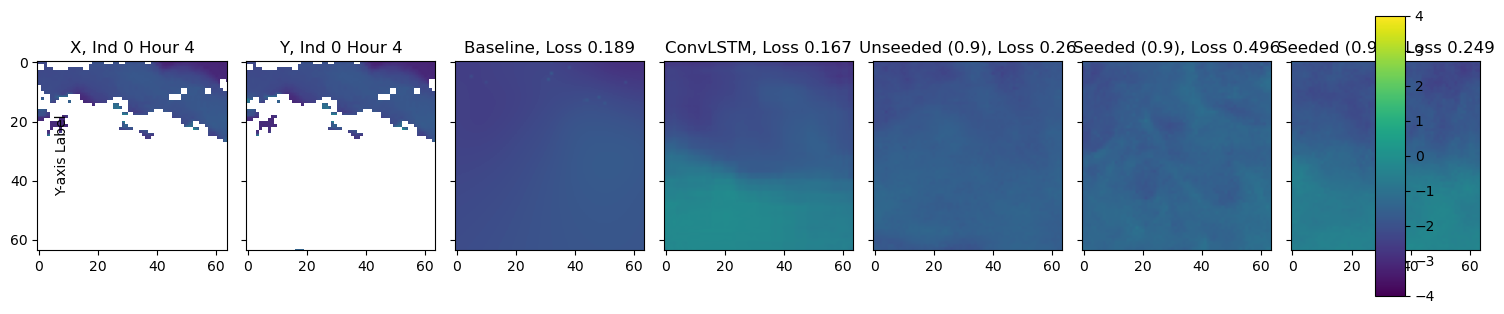

5
-3.7140064 -1.2643343
Done


<Figure size 640x480 with 0 Axes>

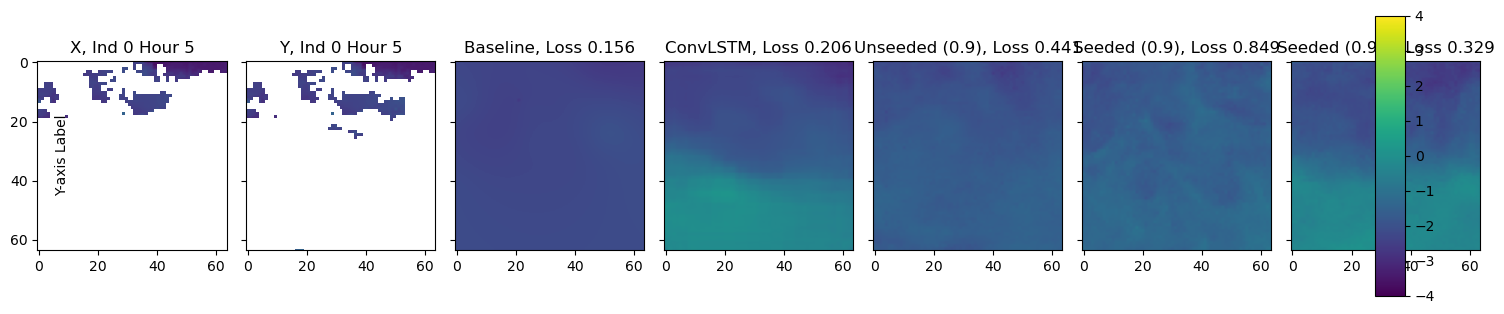

6
-3.6262894 -2.128536
Done


<Figure size 640x480 with 0 Axes>

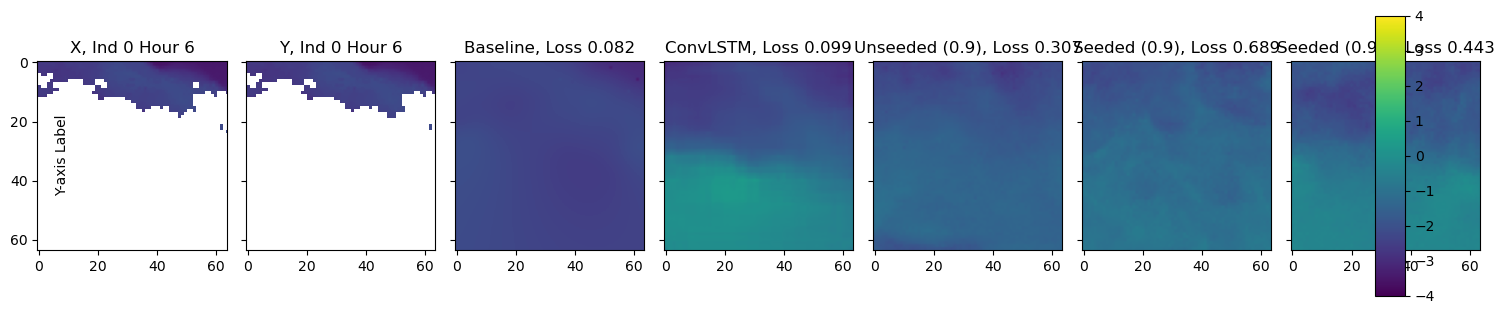

7
-3.7334993 -2.1512907
Done


<Figure size 640x480 with 0 Axes>

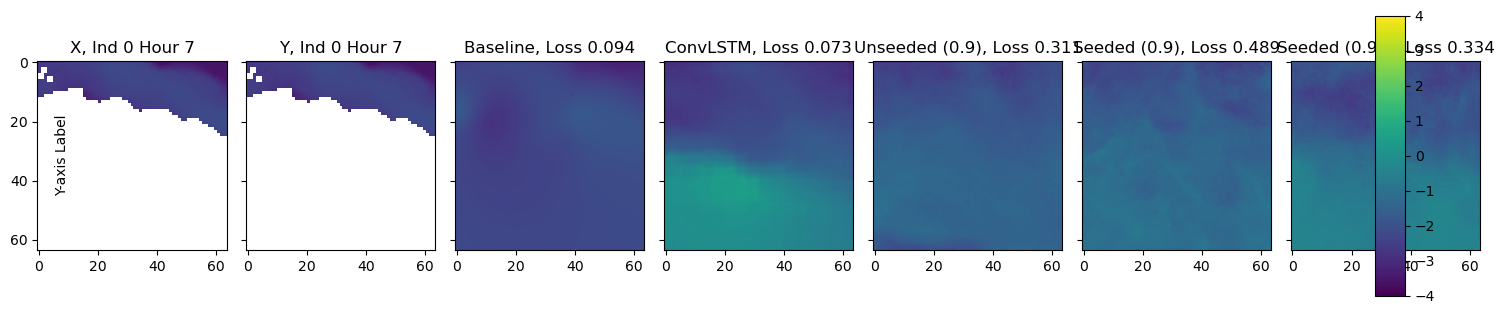

8
-3.7833314 1.2373315
Done


<Figure size 640x480 with 0 Axes>

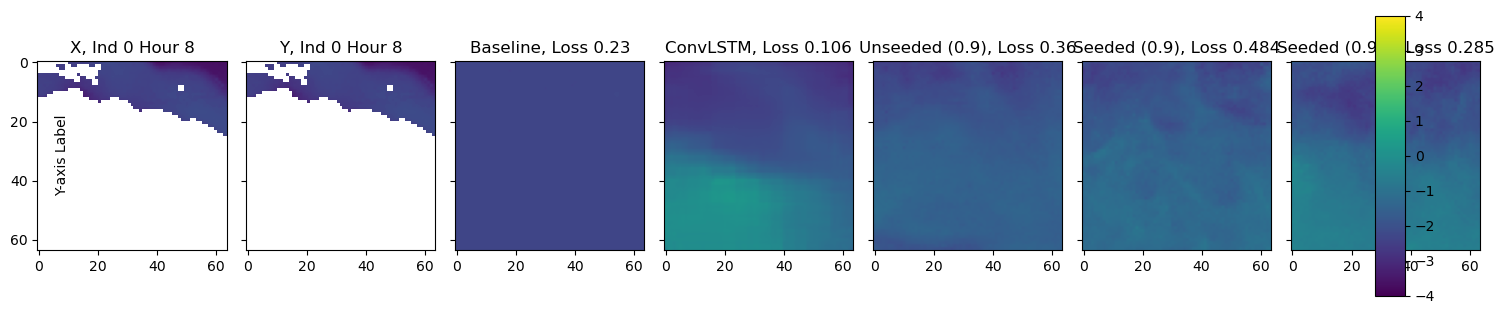

9
-3.6576898 5.954757
Done


<Figure size 640x480 with 0 Axes>

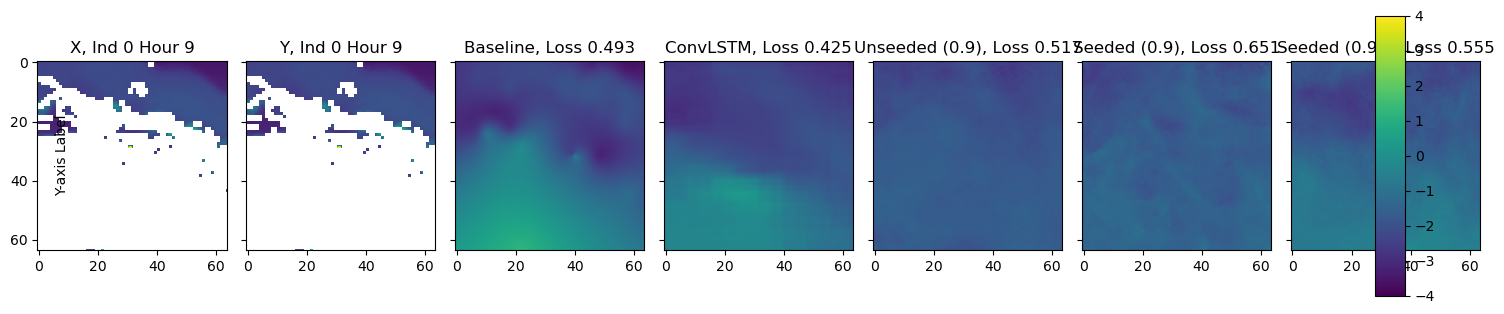

10
-3.532088 3.1260257
Done


<Figure size 640x480 with 0 Axes>

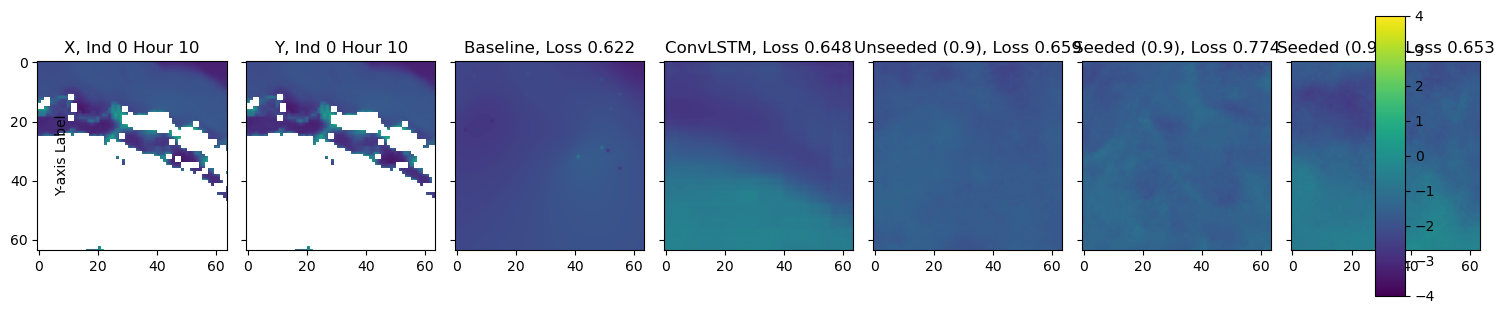

11
-3.6815252 0.905956
Done


<Figure size 640x480 with 0 Axes>

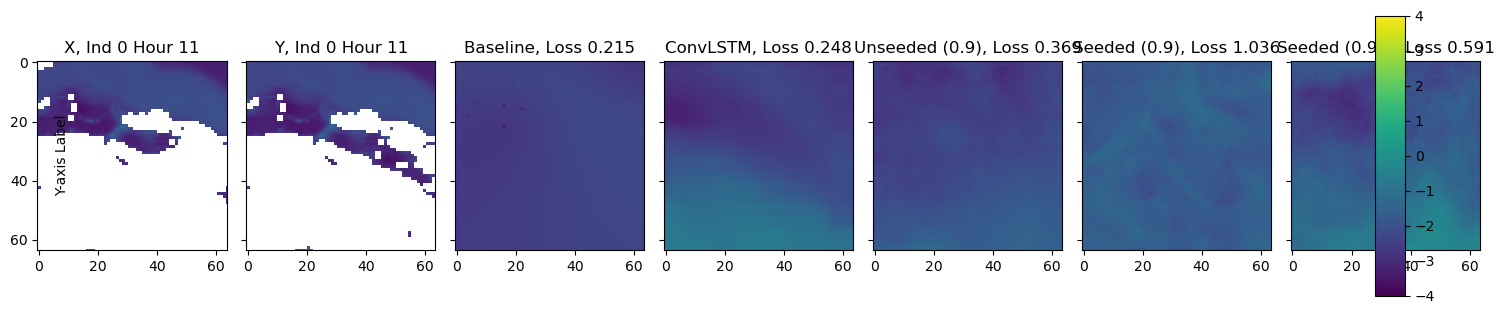

<Figure size 640x480 with 0 Axes>

In [53]:
for i in range(12):
    print(i)
    show_hour_np(np_x, np_y, 0, i, np_pred_models)
    plt.clf()

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import imageio

# Function to display subplots for a given index i
def display_subplots(i):
    # Replace this with your code to generate data and create subplots based on the index i
    x = np.linspace(0, 2 * np.pi, 100)
    y = np.sin(x + 0.1 * i)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(x, y)
    ax.set_title(f'Index i = {i}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Save the plot as an image frame
    plt.savefig(f'frame_{i:03d}.png')
    plt.close()
    
def save_hour_np(np_x, np_y, ind, hour, np_pred_models = []):
    np_x = np_x.copy()
    np_y = np_y.copy()
    np_pred_models = np_pred_models.copy()

    vmin = np.nanmin(np_y[ind, hour, :, :])
    vmax = np.nanmax(np_y[ind, hour, :, :])
    print(vmin, vmax)
    vmin = -4
    vmax = 4
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)  # Adjust vmin and vmax as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    np_pred_baseline = baseline_predict(np_x[ind, :, :, :])
    
    np_x = np_x[ind, hour, :, :]
    np_y = np_y[ind, hour, :, :]
    np_pred_baseline = np_pred_baseline[hour, :, :]
    for i in range(len(np_pred_models)):
        np_pred_models[i] = {'name': np_pred_models[i]['name'], 'pred': np_pred_models[i]['pred'][ind, hour, :, :]}
    
    np_x[np_x == 0] = np.nan
    
    baseline_loss = np_mse_loss(np_y, np_pred_baseline)
    models_loss = [np_mse_loss(np_y, np_model['pred']) for np_model in np_pred_models]
    
    fig, axs = plt.subplots(1, len(np_pred_models) + 3, figsize=(15, 4), sharey=True)
    
    axs[0].imshow(np_x, cmap=cmap, norm=norm)
    axs[0].set_title(f"X, Ind {ind} Hour {hour}")
    axs[1].imshow(np_y, cmap=cmap, norm=norm)
    axs[1].set_title(f"Y, Ind {ind} Hour {hour}")
    
    axs[2].imshow(np_pred_baseline, cmap=cmap, norm=norm)
    axs[2].set_title(f"Baseline, Loss {int(baseline_loss * 1000)/1000}")
    
    for i in range(len(np_pred_models)):
        axs[i+3].imshow(np_pred_models[i]['pred'], cmap=cmap, norm=norm)
        axs[i+3].set_title(f"{np_pred_models[i]['name']}, Loss {int(models_loss[i] * 1000)/1000}")
    
    # Add a color bar on the right of all subplots
    # Create a ScalarMappable object using a color map (you can change 'viridis' to any other colormap)
    
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    plt.colorbar(sm, cax=cax)

    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Y-axis Label', va='center', rotation='vertical')

    # Adjust the layout to avoid overlapping titles
    plt.tight_layout()

    # Show the plot
    # Save the plot as an image frame
    plt.savefig(f'frame_{hour:03d}.png')
    plt.close()
    
# Create a GIF with indices ranging from 0 to 100
frames = []
for i in range(12):
    save_hour_np(np_x, np_y, 0, i, np_pred_models)
    frames.append(imageio.imread(f'frame_{i:03d}.png'))

# Save the frames as a GIF
imageio.mimsave('subplots_animation_2.gif', frames, duration=0.2)

# # Clean up temporary image frames
# for i in range(101):
#     file_path = f'frame_{i:03d}.png'
#     if os.path.exists(file_path):
#         os.remove(file_path)

-3.0414894 -1.691025
Done


/tmp/ipykernel_6323/1548688782.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_6323/1548688782.py:84: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'frame_{i:03d}.png'))


-3.2808182 -1.8523866
Done
-3.3111446 -1.8556386
Done
-3.3241398 3.3816051
Done
-3.3154807 0.6828511
Done
-3.7140064 -1.2643343
Done
-3.6262894 -2.128536
Done
-3.7334993 -2.1512907
Done
-3.7833314 1.2373315
Done
-3.6576898 5.954757
Done
-3.532088 3.1260257
Done
-3.6815252 0.905956
Done


In [14]:
trained_ConvLSTM = get_trained_ConvLSTM("experiments/experiment_2023-08-03_02:19:24.014765")
trained_GAN_ConvLSTM_Seeded_1 = get_trained_ConvLSTM_Seeded("experiments/gan_experiment_2023-08-02_16:13:40.661113")
trained_GAN_ConvLSTM_Seeded_2 = get_trained_ConvLSTM_Seeded("experiments/gan_experiment_2023-08-03_13:04:40.793733")
trained_GAN_ConvLSTM_Unseeded = get_trained_ConvLSTM("experiments/unseed_gan_experiment_2023-08-02_21:29:26.169057")

In [15]:
models = [{'model': trained_ConvLSTM, 'seeded': False, 'name': 'ConvLSTM'},
          {'model': trained_GAN_ConvLSTM_Unseeded, 'seeded': False, 'name': 'Unseeded (0.9)'},
          {'model': trained_GAN_ConvLSTM_Seeded_2, 'seeded': True, 'name': 'Seeded (0.9)'},
          {'model': trained_GAN_ConvLSTM_Seeded_1, 'seeded': True, 'name': 'Seeded (0.99)'}]


In [17]:
for ind in range(batch_x.shape[0]):
    for hour in range(batch_x[ind].shape[0]):
        sample = batch_x[ind, hour, :, :].numpy()
        sample[sample == 0] = np.nan
        ax1.imshow(sample)
        plt.show()
        break

In [18]:
ax1.imshow(sample)

In [19]:
plt.show()

In [63]:
evaluate_baseline(src_test_dataset)

Done
0.4424023880754809
Done
0.04121409538452999
Done
0.1348814887738043
Done
0.20558310004237573
Done
0.318980888928006
Done
0.024483952949992324
Done
0.30196415778342806
Done
0.07612313194165414
Done
0.06922875777986466
Done
0.6622116576860135
Done
0.4656481888106888
Done
0.04777625675458958
Done
0.3854160642773852
Done
0.10647848115927698
Done
0.08208827058965508
Done
0.09397055734833998
Done
0.09044736898538186
Done
0.11585498215514164
Done
0.16342355401809508
Done
0.5230912581383483
Done
0.05195992460759428
Done
0.3609174172537998
Done
0.43490057712340774
Done
0.553524516507371
Done
0.3942639149211572
Done
0.21024770449648303
Done
0.11332660696649192
Done
0.2663312663171052
Done
1.734637174881505
Done
0.31086092726220593
Done
0.8951094342424368
Done
0.1465428035507506
Done
0.13045406235901544
Done
0.1351936323875039
Done
0.04514550490371758
Done
0.15162051787823405
Done
0.08942031562781115
Done
0.05274110404950201
Done
0.12565018965242525
Done
0.08913790438776541
Done
0.1970500493

0.23869811028324742

In [61]:
evaluate_ConvLSTM(models[0]['model'], src_test_dataset)

tf.Tensor(396962.0, shape=(), dtype=float32) tf.Tensor(192862.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.06691786, shape=(), dtype=float32)
tf.Tensor(416657.0, shape=(), dtype=float32) tf.Tensor(173167.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.05688489, shape=(), dtype=float32)
tf.Tensor(438946.0, shape=(), dtype=float32) tf.Tensor(150878.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.111626685, shape=(), dtype=float32)
tf.Tensor(469643.0, shape=(), dtype=float32) tf.Tensor(120181.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.068219244, shape=(), dtype=float32)
tf.Tensor(517427.0, shape=(), dtype=float32) tf.Tensor(72397.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.048590265, shape=(), dtype=float32)
tf.Tensor(444620.0, shape=(), dtype=float32) tf.Tensor(145204.0, shape=(), dtype=float32

<tf.Tensor: shape=(), dtype=float32, numpy=0.081039995>

In [6]:
evaluate_ConvLSTM(model_1, src_val_dataset)

2023-07-27 16:27:10.324648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


tf.Tensor(251478.0, shape=(), dtype=float32) tf.Tensor(338346.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(253830.0, shape=(), dtype=float32) tf.Tensor(335994.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(301561.0, shape=(), dtype=float32) tf.Tensor(288263.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(269835.0, shape=(), dtype=float32) tf.Tensor(319989.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(326448.0, shape=(), dtype=float32) tf.Tensor(263376.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(237584.0, shape=(), dtype=float32) tf.Tensor(352240.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(237835.0, shape=(), dtype=float32) tf.Tensor(351989.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(255810.0, shape=(), dtype=float32) tf.Tensor(

<tf.Tensor: shape=(), dtype=float32, numpy=1.7346925>

In [64]:
evaluate_ConvLSTM(models[1]['model'], src_test_dataset)

tf.Tensor(396962.0, shape=(), dtype=float32) tf.Tensor(192862.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.15059328, shape=(), dtype=float32)
tf.Tensor(416657.0, shape=(), dtype=float32) tf.Tensor(173167.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.12909603, shape=(), dtype=float32)
tf.Tensor(438946.0, shape=(), dtype=float32) tf.Tensor(150878.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.26395044, shape=(), dtype=float32)
tf.Tensor(469643.0, shape=(), dtype=float32) tf.Tensor(120181.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.13157648, shape=(), dtype=float32)
tf.Tensor(517427.0, shape=(), dtype=float32) tf.Tensor(72397.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(0.111548826, shape=(), dtype=float32)
tf.Tensor(444620.0, shape=(), dtype=float32) tf.Tensor(145204.0, shape=(), dtype=float32) 

<tf.Tensor: shape=(), dtype=float32, numpy=0.17167297>

In [66]:
evaluate_ConvLSTM_Seeded(models[2]['model'], src_test_dataset)

2023-08-03 16:09:29.581218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'forward_conv_lstm2d_4/while/body/_1/forward_conv_lstm2d_4/while/convolution_7' -> 'forward_conv_lstm2d_4/while/body/_1/forward_conv_lstm2d_4/while/add_6', 'Func/forward_conv_lstm2d_4/while/body/_1/input/_116' -> 'forward_conv_lstm2d_4/while/body/_1/forward_conv_lstm2d_4/while/mul_2', 'forward_conv_lstm2d_4/while/body/_1/forward_conv_lstm2d_4/while/Tanh_1' -> 'forward_conv_lstm2d_4/while/body/_1/forward_conv_lstm2d_4/while/mul_5', 'backward_conv_lstm2d_4/while/body/_49/backward_conv_lstm2d_4/while/Tanh_1' -> 'backward_conv_lstm2d_4/while/body/_49/backward_conv_lstm2d_4/while/mul_5', 'backward_conv_lstm2d_4/while/body/_49/backward_conv_lstm2d_4/while/mul_2' -> 'backward_conv_lstm2d_4/while/body/_49/backward_conv_lstm2d_4/while/add_5', 'backward_conv_lstm2d_4/while/body/_49/backward_conv_ls

tf.Tensor(43540.0, shape=(), dtype=float32) tf.Tensor(5612.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.22544485, shape=(), dtype=float32)
tf.Tensor(26917.0, shape=(), dtype=float32) tf.Tensor(22235.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.16742721, shape=(), dtype=float32)
tf.Tensor(38954.0, shape=(), dtype=float32) tf.Tensor(10198.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.10536955, shape=(), dtype=float32)
tf.Tensor(27224.0, shape=(), dtype=float32) tf.Tensor(21928.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.08119876, shape=(), dtype=float32)
tf.Tensor(17727.0, shape=(), dtype=float32) tf.Tensor(31425.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.42473432, shape=(), dtype=float32)
tf.Tensor(49143.0, shape=(), dtype=float32) tf.Tensor(9.0, shape=(), dtype=float32) tf.Tensor(49152.0, sha

<tf.Tensor: shape=(), dtype=float32, numpy=0.17430906>

In [67]:
evaluate_ConvLSTM_Seeded(models[3]['model'], src_test_dataset)

tf.Tensor(43540.0, shape=(), dtype=float32) tf.Tensor(5612.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.21081354, shape=(), dtype=float32)
tf.Tensor(26917.0, shape=(), dtype=float32) tf.Tensor(22235.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.120375045, shape=(), dtype=float32)
tf.Tensor(38954.0, shape=(), dtype=float32) tf.Tensor(10198.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.05269094, shape=(), dtype=float32)
tf.Tensor(27224.0, shape=(), dtype=float32) tf.Tensor(21928.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.035286106, shape=(), dtype=float32)
tf.Tensor(17727.0, shape=(), dtype=float32) tf.Tensor(31425.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(0.1710693, shape=(), dtype=float32)
tf.Tensor(49143.0, shape=(), dtype=float32) tf.Tensor(9.0, shape=(), dtype=float32) tf.Tensor(49152.0, sh

<tf.Tensor: shape=(), dtype=float32, numpy=0.118908405>

In [69]:
log = pd.read_csv("experiments/experiment_2023-08-03_02:19:24.014765/log.csv")

In [70]:
print(log)

    epoch  train_gen_loss  val_gen_loss
0       1        0.272650      0.093964
1       2        0.129363      0.092829
2       3        0.107039      0.075568
3       4        0.093527      0.060992
4       5        0.082869      0.072011
5       6        0.075284      0.065805
6       7        0.069411      0.044252
7       8        0.063403      0.051548
8       9        0.059986      0.058324
9      10        0.058171      0.054632
10     11        0.054659      0.053402
11     12        0.049864      0.048157
12     13        0.051573      0.039130
13     14        0.045435      0.043897
14     15        0.044536      0.038130
15     16        0.040677      0.044888
16     17        0.041886      0.037846
17     18        0.041462      0.040940
18     19        0.043501      0.036792
19     20        0.039669      0.039174
20     21        0.036561      0.036451
21     22        0.038702      0.035585
22     23        0.035638      0.031716
23     24        0.035951      0.030547


<AxesSubplot: title={'center': 'ConvLSTM Loss Curve'}, xlabel='epoch'>

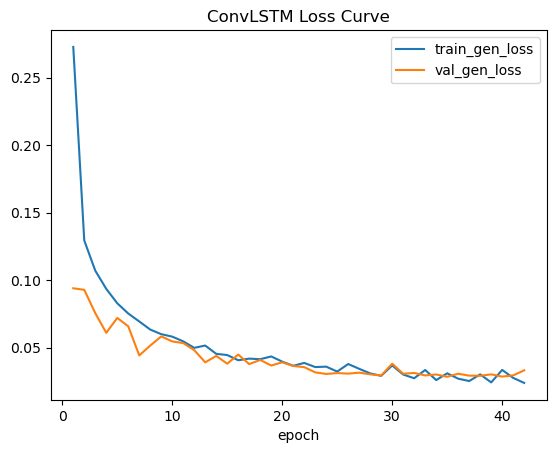

In [73]:
log.plot(x="epoch", y=["train_gen_loss", "val_gen_loss"], title="ConvLSTM Loss Curve")

In [74]:
log2 = pd.read_csv("experiments/gan_experiment_2023-08-02_16:13:40.661113/log.csv")

In [75]:
print(log2)

    epoch  train_gen_loss  train_disc_loss  train_gen_acc  val_gen_loss  \
0       1        0.244185         0.580598       0.471974      0.078501   
1       2        0.198358         0.518132       0.473730      0.094014   
2       3        0.181797         0.453773       0.478006      0.102259   
3       4        0.173296         0.406212       0.481117      0.103929   
4       5        0.168523         0.364882       0.483665      0.103854   
5       6        0.165733         0.329271       0.485620      0.108073   
6       7        0.164263         0.298794       0.487343      0.112535   
7       8        0.163659         0.273212       0.488675      0.118154   
8       9        0.163477         0.251687       0.489777      0.123326   
9      10        0.163605         0.233283       0.490664      0.126157   
10     11        0.163987         0.217697       0.491403      0.131545   

    val_disc_loss  val_gen_acc  
0        3.779444     0.928942  
1        5.378420     0.958590  


<AxesSubplot: title={'center': 'GAN-ConvLSTM(0.01) Loss Curve'}, xlabel='epoch'>

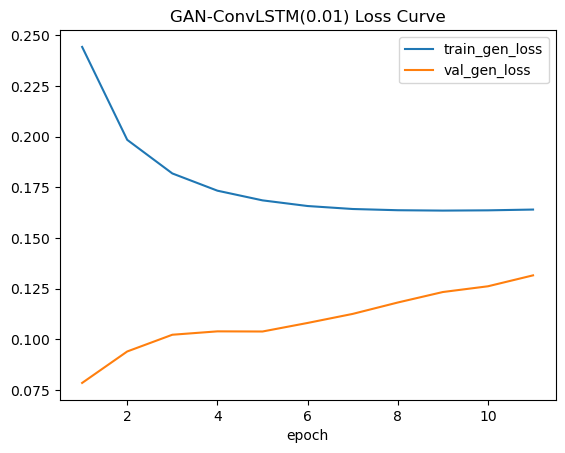

In [76]:
log2.plot(x="epoch", y=["train_gen_loss", "val_gen_loss"], title = "GAN-ConvLSTM(0.01) Loss Curve")

<AxesSubplot: title={'center': 'GAN-ConvLSTM(0.1) Loss Curve'}, xlabel='epoch'>

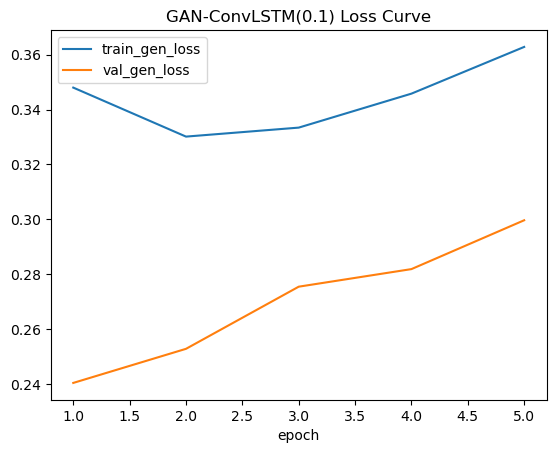

In [77]:
log3 = pd.read_csv("experiments/gan_experiment_2023-08-03_13:04:40.793733/log.csv")
log3.plot(x="epoch", y=["train_gen_loss", "val_gen_loss"], title = "GAN-ConvLSTM(0.1) Loss Curve")

<AxesSubplot: title={'center': 'GAN-ConvLSTM-Unseeded(0.1) Loss Curve'}, xlabel='epoch'>

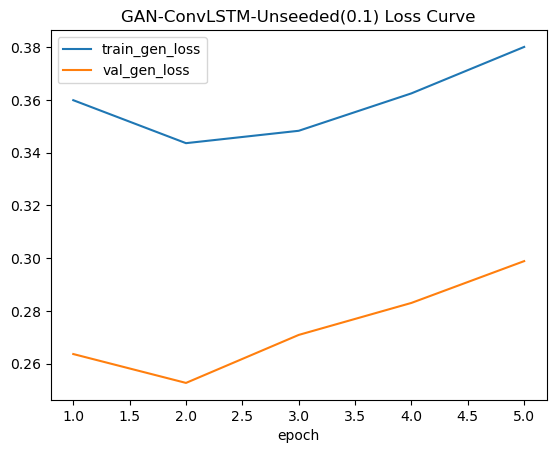

In [78]:
log4 = pd.read_csv("experiments/unseed_gan_experiment_2023-08-02_21:29:26.169057/log.csv")
log4.plot(x="epoch", y=["train_gen_loss", "val_gen_loss"], title = "GAN-ConvLSTM-Unseeded(0.1) Loss Curve")